In [0]:
import numpy as np
import torch
import pickle
from torchvision import datasets, transforms
import torchvision.utils as vutils
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import time
import torch.optim as optim

import matplotlib.pyplot  as plt
import matplotlib.animation as animation
%matplotlib inline

from IPython.display import HTML

In [0]:
batch_size = 1000

# cpu or gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number Gpus
ngpu = 1

# Size of z latent vector (i.e. size of generator input)
nz = 20

# output size
n_out = 2

# Number of training epochs
EPOCHS = 3

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [0]:
def sample_data():
  count = 100000
  rand = np.random.RandomState(0)
  a1 = [[0, 3]] + rand.randn(count // 3, 2) * 0.2
  a2 = [[0, -3]] + rand.randn(count // 3, 2) * 0.2
  a3 = [[3, 0]] + rand.randn(count // 3, 2) * 0.2
  a4 = [[-3, 0]] + rand.randn(count // 3, 2) * 0.2
  a5 = [[-2, 2.23]] + rand.randn(count // 3, 2) * 0.2
  a6 = [[2.23, -2]] + rand.randn(count // 3, 2) * 0.2
  a7 = [[-2.23, -2]] + rand.randn(count // 3, 2) * 0.2
  a8 = [[2, 2.23]] + rand.randn(count // 3, 2) * 0.2
  data_x = np.concatenate([a1, a2, a3, a4, a5, a6, a7, a8], axis=0)
  perm = rand.permutation(len(data_x))
  return data_x[perm]

In [4]:
data = sample_data()

print("data shape:",data.shape)
print("data example:", data[0])

data shape: (266664, 2)
data example: [2.08119468 2.38366341]


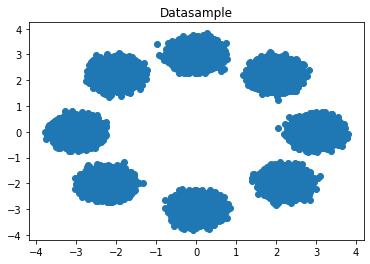

In [5]:
plt.scatter(data[:,0], data[:,1])
plt.title("Datasample")
plt.show()

In [0]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, x, transform=None):
    self.x = torch.from_numpy(x).float()
    self.transform = transform
      
  def __getitem__(self, index):
    x = self.x[index]
    
    if self.transform:
      x = self.transform(y)
    return x
  
  def __len__(self):
    return len(self.x)

In [7]:
train_ds = MyDataset(data[:260000])
len(train_ds)

260000

In [0]:
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [0]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # input is Z, going into a convolution
        nn.Linear(nz, 1024),
        nn.ReLU(True),

        nn.Linear(1024, 512),
        nn.ReLU(True),

        nn.Linear(512, 256),
        nn.ReLU(True),
      
        nn.Linear(256, n_out),
        nn.Tanh()
    )

  def forward(self, input):
    out = self.main(input)
    # print("Ge out:", out.shape)
    return out

In [10]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Linear(in_features=20, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=256, out_features=2, bias=True)
    (7): Tanh()
  )
)


In [0]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # input is Z, going into a convolution
        nn.Linear(n_out, 1024),
        nn.ReLU(True),

        nn.Linear(1024, 512),
        nn.ReLU(True),

        nn.Linear(512, 256),
        nn.ReLU(True),
      
        nn.Linear(256, 1),
        nn.Sigmoid()
    )

  def forward(self, input):
    out = self.main(input)
    # print("Ge out:", out.shape)
    return out

In [12]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=2, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [0]:
def train_d_net_with_real(data, label):
  '''
  Update D network: maximize log(D(x)) + log(1 - D(G(z)))
  '''
  ## Train with all-real batch
  netD.zero_grad()
  # Format batch
  real_cpu = data.to(device)

  # Forward pass real batch through D
  output = netD(real_cpu).view(-1)
  # print("real_out:", output.shape)
  # Calculate loss on all-real batch
  errD_real = criterion(output, label)
  # Calculate gradients for D in backward pass
  errD_real.backward()
  D_x = output.mean().item()
  return errD_real, D_x

In [0]:
def train_d_net_with_fake(label, fake, errD_real):
  '''
  Train with all-fake batch
  '''
  
  label.fill_(fake_label)
  # Classify all fake batch with D
  output = netD(fake.detach()).view(-1)
  # Calculate D's loss on the all-fake batch
  errD_fake = criterion(output, label)
  # Calculate the gradients for this batch
  errD_fake.backward()
  D_G_z1 = output.mean().item()
  # Add the gradients from the all-real and all-fake batches
  errD = errD_real + errD_fake
  # Update D
  optimizerD.step()
  return errD, D_G_z1

In [0]:
def train_g_net(data, label, fake):
  '''
  Update G network: maximize log(D(G(z)))
  '''
  netG.zero_grad()
  label.fill_(real_label)  # fake labels are real for generator cost
  # Since we just updated D, perform another forward pass of all-fake batch through D
  output = netD(fake).view(-1)
  # Calculate G's loss based on this output
  errG = criterion(output, label)
  # Calculate gradients for G
  errG.backward()
  D_G_z2 = output.mean().item()
  # Update G
  optimizerG.step()

  return errG, D_G_z2

In [0]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(EPOCHS):
  netG.train()
  netD.train()
  for i, x in enumerate(trainloader, 0):
    x = x.to(device).float()
    
    b_size = x.size(0)
    label = torch.full((b_size,), real_label, device=device)

    errD_real, D_x = train_d_net_with_real(x, label)

    # Generate batch of latent vectors
    noise = torch.randn(batch_size, nz, device=device)
    # Generate fake image batch with G
    fake = netG(noise)

    errD, D_G_z1 = train_d_net_with_fake(label, fake, errD_real)

    errG, D_G_z2 = train_g_net(x, label, fake)


    # print stats
    if i % 20 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 50 == 0) or ((epoch == EPOCHS-1) and (i == len(trainloader)-1)):
      with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
      img_list.append(fake)

    iters += 1

[0/3][0/260]	Loss_D: 1.3957	Loss_G: 0.7242	D(x): 0.4818	D(G(z)): 0.4859 / 0.4847
[0/3][20/260]	Loss_D: 0.2602	Loss_G: 1.9205	D(x): 0.9372	D(G(z)): 0.1694 / 0.1465
[0/3][40/260]	Loss_D: 0.0444	Loss_G: 3.5374	D(x): 0.9883	D(G(z)): 0.0314 / 0.0291
[0/3][60/260]	Loss_D: 0.0143	Loss_G: 4.5715	D(x): 0.9968	D(G(z)): 0.0110 / 0.0103
[0/3][80/260]	Loss_D: 0.0075	Loss_G: 5.2177	D(x): 0.9982	D(G(z)): 0.0057 / 0.0054
[0/3][100/260]	Loss_D: 0.0046	Loss_G: 5.7287	D(x): 0.9988	D(G(z)): 0.0033 / 0.0033
[0/3][120/260]	Loss_D: 0.0031	Loss_G: 6.1431	D(x): 0.9991	D(G(z)): 0.0022 / 0.0021
[0/3][140/260]	Loss_D: 0.0021	Loss_G: 6.5031	D(x): 0.9995	D(G(z)): 0.0015 / 0.0015
[0/3][160/260]	Loss_D: 0.0013	Loss_G: 6.8345	D(x): 0.9997	D(G(z)): 0.0011 / 0.0011
[0/3][180/260]	Loss_D: 0.0011	Loss_G: 7.0884	D(x): 0.9998	D(G(z)): 0.0009 / 0.0008
[0/3][200/260]	Loss_D: 0.0009	Loss_G: 7.3242	D(x): 0.9998	D(G(z)): 0.0007 / 0.0007


In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.scatter(i[:,0], i[:,1])] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [0]:
print(len(img_list))
print(img_list[1].shape)
print(img_list[1])